# MNIST Visualization with Metric Learning Setup

In [1]:
import os
import os.path
import sys
from IPython.display import clear_output
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data.sampler import Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Model

In [2]:
from model.mnist_model import NetWithoutBatchNorm
model = NetWithoutBatchNorm()
# Load weigths from the model trained on upstream task
model_file = './mnist.pth'
state_dict = torch.load(model_file)
model.load_state_dict(state_dict)

# Decide whether to freeze or finetune the model
for param in model.parameters():
    param.requires_grad = False

model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)

NetWithoutBatchNorm(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (g): Linear(in_features=10, out_features=3, bias=True)
)


## Load MNIST

torch.Size([1000, 1, 28, 28])
tensor(9)
tensor(3)


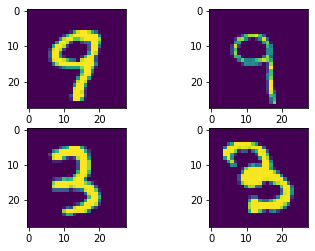

In [3]:
root_directory = '../data/mnist_png/training'

from data_util.npair_dataset import FramePairsDataset
from data_util.npair_sampler import VideoFrameSampler
import data_util.simclr_transforms as custom_transform

batch_size = 1000
frames_per_epoch = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = FramePairsDataset(root_directory, '.png', distance=15, transform=transform)

sampler = VideoFrameSampler(len(dataset), frames_per_epoch, 1000)

data_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

def test_data_loader(data_loader):
    anchors, positives, labels = iter(data_loader).next()
    print(anchors.shape)
    anchors = anchors.permute(0,2,3,1)
    positives = positives.permute(0,2,3,1)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    print(labels[0])
    ax1.imshow(anchors[0].squeeze(-1))
    ax2.imshow(positives[0].squeeze(-1))
    print(labels[1])
    ax3.imshow(anchors[1].squeeze(-1))
    ax4.imshow(positives[1].squeeze(-1))
    
test_data_loader(data_loader)

## Visualizations

<IPython.core.display.Javascript object>


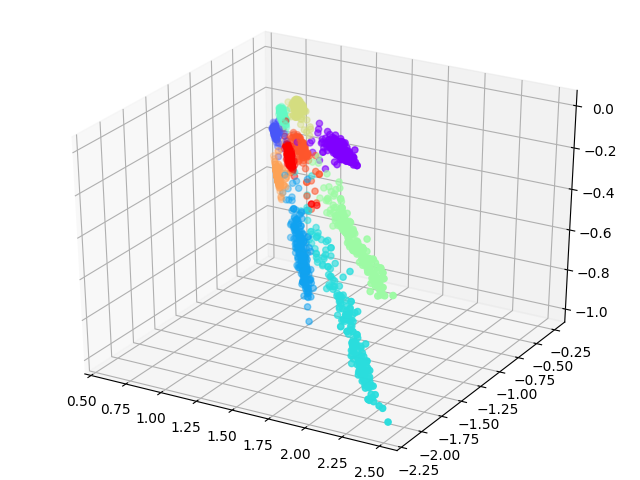

In [9]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

anchors, positives, labels = iter(data_loader).next()
samples = torch.cat((anchors, positives), dim=0)
labels = torch.cat((labels, labels), dim=0)
#print(samples.shape)
#print(labels.shape)

samples = samples.to(device)
rep = model(samples)
X = rep[:, 0]
Y = rep[:, 1]
Z = rep[:, 2]

#2D Graph
#plt.scatter(X.cpu(), Y.cpu(), Z.cpu(), c=labels, cmap='rainbow')
#plt.show()

#3D Graph
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X.cpu(), Y.cpu(), Z.cpu(), c=labels, cmap='rainbow')
plt.show()

<IPython.core.display.Javascript object>


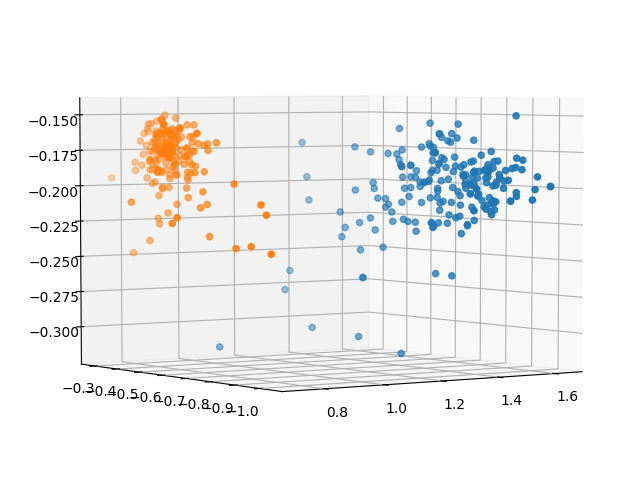

In [18]:
%matplotlib notebook
mask0 = labels == 0
rep0 = rep[mask0]
X0 = rep0[:,0]
Y0 = rep0[:,1]
Z0 = rep0[:,2]

mask6 = labels == 6
rep6 = rep[mask6]
X6 = rep6[:,0]
Y6 = rep6[:,1]
Z6 = rep6[:,2]

mask8 = labels == 8
rep8 = rep[mask8]
X8 = rep8[:,0]
Y8 = rep8[:,1]

mask3 = labels == 3
rep3 = rep[mask3]
X3 = rep3[:,0]
Y3 = rep3[:,1]

#3D Graphs
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X0.cpu(), Y0.cpu(), Z0.cpu(), cmap='r')
ax.scatter(X6.cpu(), Y6.cpu(), Z6.cpu(), cmap='b')
plt.show()

# 2D Graphs
#plt.scatter(X0.cpu(), Y0.cpu(), cmap= 'g')
#plt.scatter(X8.cpu(), Y8.cpu(), cmap = 'r')
#plt.scatter(X3.cpu(), Y3.cpu(), cmap = 'b')

#8, 6 and 3 are indifferentiable